# 2D Geometry File Parsing

This notebook demonstrates parsing and manipulating 2D geometry elements from HEC-RAS plain text geometry files, including:
- Storage Area operations
- SA/2D Connection operations (dam breach analysis)
- Dam crest profiles and gate extraction
- Practical dam breach workflow

## Overview

This notebook demonstrates extraction of **2D geometry elements** from HEC-RAS geometry files. 2D areas use computational meshes rather than cross sections.

### What You'll Learn
- Extract 2D flow area boundaries
- Parse computational mesh cell data
- Read Manning's n tables and breaklines
- Understand 2D/1D connections

### LLM Forward Approach
- **Verification**: Compare mesh cell count to HEC-RAS GUI
- **Visual Outputs**: Plot 2D area boundaries and mesh
- **Audit Trail**: Export mesh geometry to GeoJSON

### Reference Documentation
- [HEC-RAS 2D Modeling User's Manual](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)
- [HEC-RAS User's Manual, Chapter 6](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
from pathlib import Path
import sys

USE_LOCAL_SOURCE = True  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import RAS Commander geometry modules
from ras_commander import (
    RasGeometry, GeomLateral,
    RasGeometryUtils,
    HdfHydraulicTables,
    RasExamples,
    init_ras_project,
    RasCmdr,
    ras
)

# Additional imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")
print(f"Working directory: {Path.cwd()}")

📁 LOCAL SOURCE MODE: Loading from c:\GH\ras-commander/ras_commander
✓ Loaded: c:\GH\ras-commander\ras_commander\__init__.py
Working directory: c:\GH\ras-commander\examples


## Parameters

Configure these values to customize the notebook for your project.

In [2]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "BaldEagleCrkMulti2D"  # 2D example project with storage areas and connections
RAS_VERSION = "6.6"                    # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# Geometry Settings
GEOM_NUMBER = "12"                # Geometry file with SA/2D connections
RIVER = None                      # Not applicable for 2D geometry
REACH = None                      # Not applicable for 2D geometry
CROSS_SECTION = None              # Not applicable for 2D geometry

## Package Setup and Imports

In [3]:
# Extract and initialize the 2D example project
project_path = RasExamples.extract_project(PROJECT_NAME, suffix="202")
init_ras_project(project_path, RAS_VERSION)

print(f"✓ Project initialized: {project_path}")
print(f"✓ Found {len(ras.geom_df)} geometry files")
print(f"✓ Found {len(ras.plan_df)} plan files")

2025-12-28 23:42:37 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2025-12-28 23:42:37 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-12-28 23:42:37 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-12-28 23:42:37 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-28 23:42:37 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' as 'BaldEagleCrkMulti2D_202'
2025-12-28 23:42:37 - ras_commander.RasExamples - INFO - Folder 'BaldEagleCrkMulti2D_202' already exists. Deleting existing folder...
2025-12-28 23:42:37 - ras_commander.RasExamples - INFO - Existing folder 'BaldEagleCrkMulti2D_202' has been deleted.
2025-12-28 23:42:39 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_202
2025-12-28 23:42:39 - ras_commander.

✓ Project initialized: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_202
✓ Found 10 geometry files
✓ Found 11 plan files


## Section 1: Storage Area Operations

Storage areas represent reservoirs, detention basins, or other water storage features in the HEC-RAS model. We'll demonstrate extracting storage area properties and elevation-volume curves.

### 1.1 List Storage Areas

#### Select Geometry 12 (SA to 2D Connection)

Geometry 12 in the BaldEagleCrkMulti2D project contains storage areas and SA/2D connections for dam breach analysis.

In [4]:
# Select geometry 12 which has SA/2D connections for dam breach analysis
geom_number = GEOM_NUMBER
geom_row = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number].iloc[0]

geom_file = Path(geom_row["full_path"])
geom_hdf = Path(geom_row["hdf_path"])

print(f"Selected geometry: {geom_file.name}")
print(f"Geometry HDF: {geom_hdf.name if Path(geom_hdf).exists() else 'Not yet created'}")

Selected geometry: BaldEagleDamBrk.g12
Geometry HDF: BaldEagleDamBrk.g12.hdf


In [5]:
ras.geom_df

,geom_file,geom_number,full_path,hdf_path
0,g06,06,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
1,g08,08,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
2,g10,10,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
3,g11,11,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
4,g12,12,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
5,g09,09,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
6,g13,13,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
7,g01,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
8,g03,03,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
9,g02,02,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...


In [6]:
# Path to dam breach geometry with storage areas
dam_geom_file = geom_file

print(f"Geometry file: {dam_geom_file.name}")

# Get storage areas (excluding 2D flow areas)
storage_areas = RasGeometry.get_storage_areas(dam_geom_file, exclude_2d=True)

print(f"\nTraditional storage areas found: {len(storage_areas)}")
for i, name in enumerate(storage_areas, 1):
    print(f"  {i}. {name}")

# Get all storage areas (including 2D)
all_storage = RasGeometry.get_storage_areas(dam_geom_file, exclude_2d=False)

print(f"\nAll storage areas (including 2D): {len(all_storage)}")
for i, name in enumerate(all_storage, 1):
    print(f"  {i}. {name}")

2025-12-28 23:42:39 - ras_commander.geom.GeomStorage - INFO - Found 1 storage areas in BaldEagleDamBrk.g12
2025-12-28 23:42:39 - ras_commander.geom.GeomStorage - INFO - Found 2 storage areas in BaldEagleDamBrk.g12


Geometry file: BaldEagleDamBrk.g12

Traditional storage areas found: 1
  1. Reservoir Pool

All storage areas (including 2D): 2
  1. BaldEagleCr
  2. Reservoir Pool


### 1.2 Extract Elevation-Volume Curve

In [7]:
# Get elevation-volume curve for first storage area
if len(storage_areas) > 0:
    area_name = storage_areas[0]
    print(f"Extracting elevation-volume curve for: {area_name}")
    
    try:
        elev_vol = RasGeometry.get_storage_elevation_volume(dam_geom_file, area_name)

        print(f"\nStorage Curve Data:")
        print(f"  Points: {len(elev_vol)}")
        print(f"  Elevation range: {elev_vol['Elevation'].min():.2f} to {elev_vol['Elevation'].max():.2f} ft")
        print(f"  Volume range: {elev_vol['Volume'].min():.0f} to {elev_vol['Volume'].max():.0f} cu ft")

        print("\nFirst 10 points:")
        display.display(elev_vol.head(10))
    except ValueError as e:
        print(f"\nNote: Could not extract elevation-volume curve: {e}")
        print("This may be a 2D flow area without traditional storage curve data.")
        print("Trying second storage area if available...")
        
        if len(storage_areas) > 1:
            area_name = storage_areas[1]
            print(f"\nTrying: {area_name}")
            try:
                elev_vol = RasGeometry.get_storage_elevation_volume(dam_geom_file, area_name)
                print(f"Storage Curve Data:")
                print(f"  Points: {len(elev_vol)}")
                display.display(elev_vol.head(10))
            except ValueError as e2:
                print(f"Could not extract from {area_name} either: {e2}")
                elev_vol = pd.DataFrame({'Elevation': [], 'Volume': []})
        else:
            elev_vol = pd.DataFrame({'Elevation': [], 'Volume': []})
else:
    print("No traditional storage areas found in this geometry file")
    elev_vol = pd.DataFrame({'Elevation': [], 'Volume': []})

2025-12-28 23:42:39 - ras_commander.geom.GeomStorage - INFO - Extracted 52 elevation-volume points for Reservoir Pool


Extracting elevation-volume curve for: Reservoir Pool

Storage Curve Data:
  Points: 52
  Elevation range: 583.00 to 683.00 ft
  Volume range: 0 to 212000 cu ft

First 10 points:


,Elevation,Volume
0,583.0,0.00
1,588.0,0.01
2,590.0,20.00
3,592.0,80.00
4,594.0,180.00
5,596.0,360.00
6,598.0,760.00
7,600.0,1390.00
8,602.0,2160.00
9,604.0,3030.00


### 1.3 Visualize Storage Curve

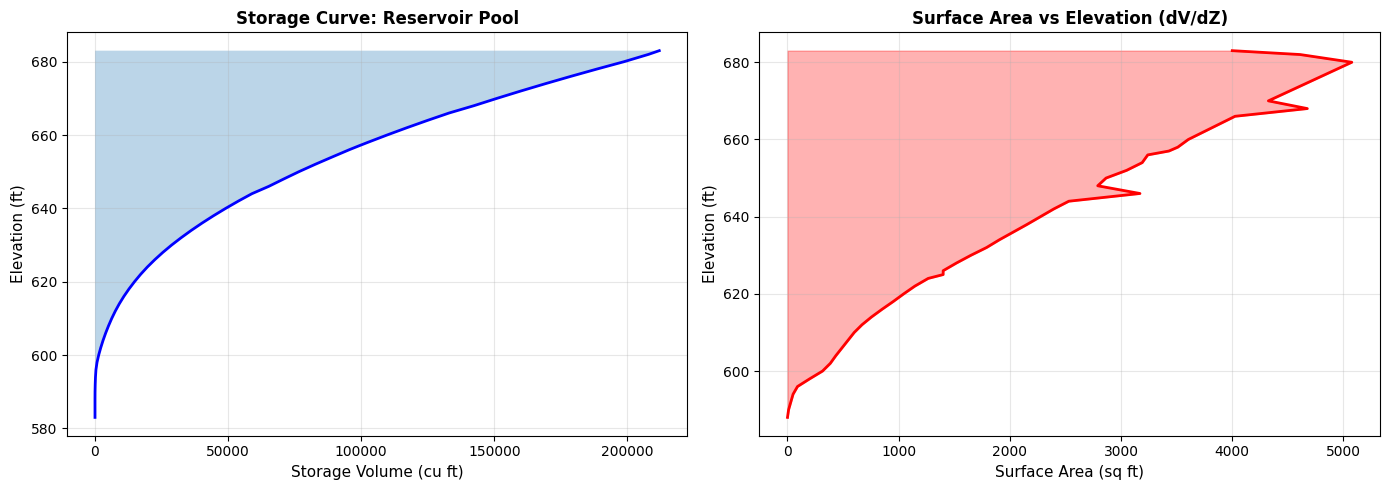


Storage Statistics:
  Total storage capacity: 212000 cu ft
  Elevation range: 100.0 ft
  Average surface area: 2213 sq ft


In [8]:
if len(storage_areas) > 0 and len(elev_vol) > 0:
    # Plot elevation-volume curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Volume vs Elevation
    ax1.plot(elev_vol['Volume'], elev_vol['Elevation'], 'b-', linewidth=2)
    ax1.fill_betweenx(elev_vol['Elevation'], 0, elev_vol['Volume'], alpha=0.3)
    ax1.set_xlabel('Storage Volume (cu ft)', fontsize=11)
    ax1.set_ylabel('Elevation (ft)', fontsize=11)
    ax1.set_title(f'Storage Curve: {area_name}', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Incremental Storage (dV/dZ)
    elev_vol['dV'] = elev_vol['Volume'].diff()
    elev_vol['dZ'] = elev_vol['Elevation'].diff()
    elev_vol['Surface_Area'] = elev_vol['dV'] / elev_vol['dZ']

    ax2.plot(elev_vol['Surface_Area'], elev_vol['Elevation'], 'r-', linewidth=2)
    ax2.fill_betweenx(elev_vol['Elevation'], 0, elev_vol['Surface_Area'], alpha=0.3, color='red')
    ax2.set_xlabel('Surface Area (sq ft)', fontsize=11)
    ax2.set_ylabel('Elevation (ft)', fontsize=11)
    ax2.set_title('Surface Area vs Elevation (dV/dZ)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nStorage Statistics:")
    print(f"  Total storage capacity: {elev_vol['Volume'].max():.0f} cu ft")
    print(f"  Elevation range: {elev_vol['Elevation'].max() - elev_vol['Elevation'].min():.1f} ft")
    print(f"  Average surface area: {elev_vol['Surface_Area'].mean():.0f} sq ft")
else:
    print("Skipping storage visualization - no storage area data available")
    print("Note: This geometry may use 2D flow areas instead of traditional storage areas.")

## Section 2: SA/2D Connection Operations

Connections link storage areas to 2D flow areas for dam breach analysis. We'll extract connection properties, dam crest profiles, and gate information.

### 2.1 List All Connections

In [9]:
# Extract all connections
connections = RasGeometry.get_connections(dam_geom_file)

print(f"SA/2D Connections found: {len(connections)}")

if len(connections) > 0:
    print("\nConnection inventory:")
    display.display(connections[['Connection_Name', 'Upstream_Area', 'Downstream_Area',
                                  'Weir_Width', 'Weir_Coefficient', 'SE_Count', 'Num_Gates']])

    print("\nConnection summary:")
    print(f"  Total weir width: {connections['Weir_Width'].sum():.1f} ft")
    print(f"  Total gates: {connections['Num_Gates'].sum():.0f}")
    print(f"  Weir coefficient range: {connections['Weir_Coefficient'].min():.2f} to {connections['Weir_Coefficient'].max():.2f}")
else:
    print("No connections found in this geometry file")

2025-12-28 23:42:39 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12


SA/2D Connections found: 0
No connections found in this geometry file


### 2.2 Extract Dam Crest Profile

In [10]:
if len(connections) > 0:
    # Get weir profile for first connection
    conn_name = connections.iloc[0]['Connection_Name']

    print(f"Extracting weir profile for connection: {conn_name}")
    print(f"  Upstream: {connections.iloc[0]['Upstream_Area']}")
    print(f"  Downstream: {connections.iloc[0]['Downstream_Area']}")

    weir_profile = RasGeometry.get_connection_weir_profile(dam_geom_file, conn_name)

    print(f"\nWeir/Dam Crest Profile:")
    print(f"  Points: {len(weir_profile)}")
    print(f"  Station range: {weir_profile['Station'].min():.1f} to {weir_profile['Station'].max():.1f} ft")
    print(f"  Elevation range: {weir_profile['Elevation'].min():.2f} to {weir_profile['Elevation'].max():.2f} ft")
    print(f"  Crest length: {weir_profile['Station'].max() - weir_profile['Station'].min():.1f} ft")

    print("\nFirst 10 points:")
    display.display(weir_profile.head(10))
else:
    print("Skipping weir profile extraction - no connections found")

Skipping weir profile extraction - no connections found


### 2.3 Visualize Dam Crest Profile

In [11]:
if len(connections) > 0:
    # Plot weir/dam crest profile
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(weir_profile['Station'], weir_profile['Elevation'],
            'ro-', linewidth=2, markersize=6, label='Dam Crest')
    ax.fill_between(weir_profile['Station'], weir_profile['Elevation'],
                     weir_profile['Elevation'].min() - 10,
                     alpha=0.3, color='brown')

    ax.set_xlabel('Station Along Dam (ft)', fontsize=12)
    ax.set_ylabel('Crest Elevation (ft)', fontsize=12)
    ax.set_title(f'Dam Crest Profile: {conn_name}',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

    # Add statistics
    stats_text = f'Points: {len(weir_profile)}\n'
    stats_text += f'Length: {weir_profile["Station"].max() - weir_profile["Station"].min():.1f} ft\n'
    stats_text += f'Elev Range: {weir_profile["Elevation"].min():.1f} - {weir_profile["Elevation"].max():.1f} ft\n'
    stats_text += f'Weir Coef: {connections.iloc[0]["Weir_Coefficient"]:.2f}'
    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization - no connections")

Skipping visualization - no connections


### 2.4 Extract Gate Information

In [12]:
if len(connections) > 0:
    # Check which connections have gates
    conn_with_gates = connections[connections['Num_Gates'] > 0]

    if len(conn_with_gates) > 0:
        # Get gates for first connection with gates
        conn_name_with_gates = conn_with_gates.iloc[0]['Connection_Name']

        print(f"Extracting gates for connection: {conn_name_with_gates}")

        gates = RasGeometry.get_connection_gates(dam_geom_file, conn_name_with_gates)

        print(f"\nGates found: {len(gates)}")

        if len(gates) > 0:
            print("\nGate parameters:")
            display.display(gates[['Gate_Name', 'Width', 'Height', 'Invert', 'Gate_Coefficient']])

            # Visualize gate geometry
            fig, ax = plt.subplots(figsize=(8, 6))

            for idx, gate in gates.iterrows():
                # Draw gate as rectangle
                width = gate['Width']
                height = gate['Height']
                invert = gate['Invert']

                rect = plt.Rectangle((idx * 20, invert), width, height,
                                      linewidth=2, edgecolor='blue',
                                      facecolor='lightblue', alpha=0.5)
                ax.add_patch(rect)

                # Label gate
                ax.text(idx * 20 + width/2, invert + height + 2,
                        gate['Gate_Name'],
                        ha='center', fontsize=10, fontweight='bold')
                ax.text(idx * 20 + width/2, invert + height/2,
                        f"{width}' × {height}'\nInvert: {invert}'",
                        ha='center', va='center', fontsize=9)

            ax.set_xlim(-5, len(gates) * 20 + 15)
            ax.set_ylim(invert - 10, invert + height + 20)
            ax.set_xlabel('Position', fontsize=11)
            ax.set_ylabel('Elevation (ft)', fontsize=11)
            ax.set_title(f'Gate Configuration: {conn_name_with_gates}',
                         fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_aspect('equal')
            plt.tight_layout()
            plt.show()
    else:
        print("No gates found in any connections")
else:
    print("Skipping gate extraction - no connections")

Skipping gate extraction - no connections


### 2.5 Analyze All Connections

In [13]:
if len(connections) > 0:
    # Extract profiles for all connections
    print("Processing all connections...")

    for idx, conn in connections.iterrows():
        conn_name = conn['Connection_Name']

        try:
            # Get weir profile
            profile = RasGeometry.get_connection_weir_profile(dam_geom_file, conn_name)

            # Get gates
            gates = RasGeometry.get_connection_gates(dam_geom_file, conn_name)

            print(f"{idx+1}. {conn_name}:")
            print(f"   {conn['Upstream_Area']} → {conn['Downstream_Area']}")
            print(f"   Weir profile: {len(profile)} points, length={profile['Station'].max():.0f} ft")
            print(f"   Gates: {len(gates)}")
            if len(gates) > 0:
                gate = gates.iloc[0]
                print(f"     {gate['Gate_Name']}: {gate['Width']:.0f}' W × {gate['Height']:.0f}' H, Invert={gate['Invert']:.0f}'")
            print()

        except Exception as e:
            print(f"{idx+1}. {conn_name}: ERROR - {e}")
else:
    print("No connections to process")

No connections to process


## Section 3: Practical Application - Dam Breach Analysis Workflow

Real-world workflow combining storage areas, connections, and gate operations for dam breach analysis.

In [14]:
print("="*70)
print("DAM BREACH ANALYSIS WORKFLOW")
print("="*70)

# Step 1: Identify storage areas
print("\nStep 1: Storage Areas")
storage_areas = RasGeometry.get_storage_areas(dam_geom_file)
print(f"  Found {len(storage_areas)} storage area(s)")
for area in storage_areas:
    print(f"    - {area}")

# Step 2: Get storage capacity
if len(storage_areas) > 0:
    print("\nStep 2: Storage Capacity")
    elev_vol = RasGeometry.get_storage_elevation_volume(dam_geom_file, storage_areas[0])
    print(f"  Maximum storage: {elev_vol['Volume'].max():.0f} cu ft")
    print(f"  Pool elevation range: {elev_vol['Elevation'].min():.1f} to {elev_vol['Elevation'].max():.1f} ft")

# Step 3: Identify connections
print("\nStep 3: Connections")
connections = RasGeometry.get_connections(dam_geom_file)
print(f"  Found {len(connections)} connection(s)")
for idx, conn in connections.iterrows():
    print(f"    - {conn['Connection_Name']}: {conn['Upstream_Area']} → {conn['Downstream_Area']}")

# Step 4: Analyze dam crest
if len(connections) > 0:
    dam_connections = connections[connections['Connection_Name'].str.contains('Dam', case=False, na=False)]

    if len(dam_connections) > 0:
        print("\nStep 4: Dam Crest Geometry")
        dam_name = dam_connections.iloc[0]['Connection_Name']
        dam_profile = RasGeometry.get_connection_weir_profile(dam_geom_file, dam_name)

        print(f"  Dam: {dam_name}")
        print(f"  Crest length: {dam_profile['Station'].max() - dam_profile['Station'].min():.0f} ft")
        print(f"  Crest elevation range: {dam_profile['Elevation'].min():.1f} to {dam_profile['Elevation'].max():.1f} ft")
        print(f"  Min crest elevation: {dam_profile['Elevation'].min():.1f} ft")

# Step 5: Check for gates
if len(connections) > 0:
    print("\nStep 5: Gate Inventory")
    total_gates = connections['Num_Gates'].sum()
    print(f"  Total gates in model: {total_gates:.0f}")

    if total_gates > 0:
        conn_with_gates = connections[connections['Num_Gates'] > 0]
        for idx, conn in conn_with_gates.iterrows():
            gates = RasGeometry.get_connection_gates(dam_geom_file, conn['Connection_Name'])
            print(f"  {conn['Connection_Name']}: {len(gates)} gate(s)")
            for _, gate in gates.iterrows():
                print(f"    • {gate['Gate_Name']}: {gate['Width']:.0f}' × {gate['Height']:.0f}', Invert {gate['Invert']:.0f}'")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

2025-12-28 23:42:39 - ras_commander.geom.GeomStorage - INFO - Found 1 storage areas in BaldEagleDamBrk.g12
2025-12-28 23:42:39 - ras_commander.geom.GeomStorage - INFO - Extracted 52 elevation-volume points for Reservoir Pool
2025-12-28 23:42:39 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12


DAM BREACH ANALYSIS WORKFLOW

Step 1: Storage Areas
  Found 1 storage area(s)
    - Reservoir Pool

Step 2: Storage Capacity
  Maximum storage: 212000 cu ft
  Pool elevation range: 583.0 to 683.0 ft

Step 3: Connections
  Found 0 connection(s)

ANALYSIS COMPLETE


## Summary

### Methods Demonstrated

**Storage Area Operations (RasGeometry)**:
- `get_storage_areas()` - List storage areas with metadata
- `get_storage_curve()` - Extract elevation-volume relationships

**SA/2D Connection Operations (RasGeometry)**:
- `get_connections()` - List SA/2D connections
- `get_connection_weir_profile()` - Extract dam crest profiles
- `get_connection_gates()` - Extract gate geometry and parameters

### Key Capabilities

1. **Storage Analysis**: Extract elevation-volume curves for capacity analysis
2. **Dam Crest Extraction**: Profile and weir coefficient data
3. **Gate Configuration**: Position, dimensions, and operation parameters
4. **Breach Workflow**: Complete analysis pipeline for dam breach studies

### See Also

- `201_1d_plaintext_geometry.ipynb` - 1D geometry operations (cross sections, HTAB)
- `410_2d_hdf_data_extraction.ipynb` - 2D HDF results extraction
- `411_2d_hdf_pipes_and_pumps.ipynb` - Pipe and pump analysis
